<a href="https://colab.research.google.com/github/rajgit-123/MyProject/blob/master/intel_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


In [83]:
import os
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [67]:
!kaggle datasets download -d puneet6060/intel-image-classification

!unzip intel-image-classification.zip -d IntelImages

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  intel-image-classification.zip
replace IntelImages/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [84]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [85]:
print("tensorflow version", tf.__version__)

tensorflow version 2.18.0


In [86]:
import zipfile

dataset_path = "/content/intel-image-classification.zip"
extract_path = "/content/IntelImages"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

!ls /content/IntelImages

seg_pred  seg_test  seg_train


Step 3: Create Image Data Generators

Since images have different sizes, we resize them to (150x150).

In [87]:
train_dir ="/content/IntelImages/seg_train"
test_dir = "/content/IntelImages/seg_test"

train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixel values to range [0,1]
    rotation_range=20,        # Rotate images randomly by up to 20 degrees
    width_shift_range=0.2,    # Shift image horizontally by 20% of width
    height_shift_range=0.2,   # Shift image vertically by 20% of height
    shear_range=0.2,          # Apply shearing transformations
    zoom_range=0.2,           # Randomly zoom in/out up to 20%
    horizontal_flip=True      # Flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,target_size=(150,150), batch_size=32, class_mode="sparse")


test_generator = test_datagen.flow_from_directory(
    test_dir,target_size=(150,150), batch_size=32, class_mode="sparse")

print("class labels :", train_generator.class_indices)


Found 14034 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.
class labels : {'seg_train': 0}


 Step 4: Build a CNN Model

Now, create a Convolutional Neural Network (CNN):

In [88]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu',input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Step 5: Train the Model
Now, train the CNN on the dataset.

In [89]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,036,742 (72.62 MB)

 Trainable params: 19,036,742 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
epochs=10

history=model.fit(
    train_generator,
    epochs=epochs,
    validation_data = test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 17/439 ━━━━━━━━━━━━━━━━━━━━ 7:41 1s/step - accuracy: 0.7977 - loss: 0.3839

KeyboardInterrupt: 

Step 6: Evaluate the Model
Check how well the model performed:

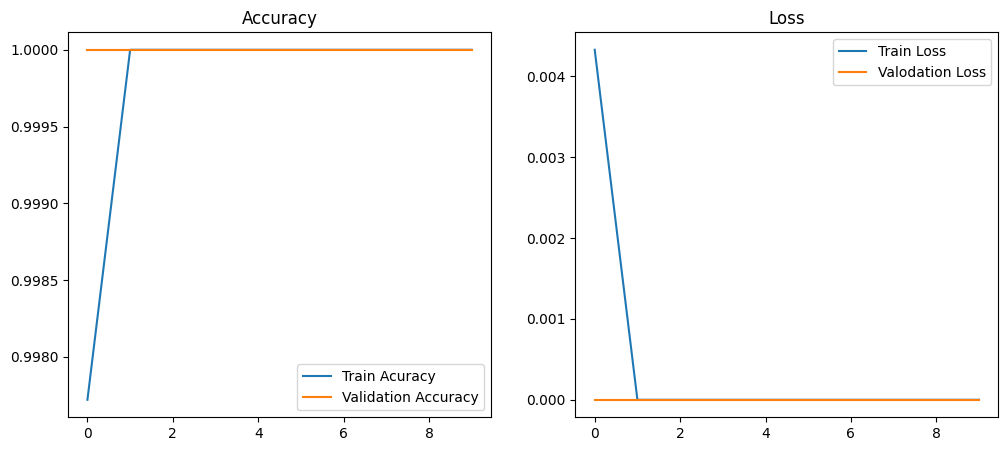

In [91]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valodation Loss')
plt.legend()
plt.title('Loss')

plt.show()

Make Predictions on Unseen Images
Use the seg_pred folder for prediction:

In [106]:
import os

folder_path = "/content/IntelImages/seg_pred/seg_pred"

if os.path.exists(folder_path):
    files = os.listdir(folder_path)
    print("Total files:", len(files))
    print("First 10 files:", files[:10])  # Show first 10 files
else:
    print("❌ Folder not found. Check the path.")



Total files: 7304
First 10 files: ['17408.jpg', '5745.jpg', '4091.jpg', '4730.jpg', '22649.jpg', '17310.jpg', '12180.jpg', '11427.jpg', '8050.jpg', '21886.jpg']


In [98]:
!ls -R /content/IntelImages

Streaming output truncated to the last 5000 lines.
11617.jpg  14055.jpg  16535.jpg  18970.jpg  21330.jpg  23789.jpg  4333.jpg  6707.jpg  9122.jpg
11619.jpg  1405.jpg   16536.jpg  18973.jpg  21331.jpg  2378.jpg   4336.jpg  6715.jpg  9123.jpg
11623.jpg  14061.jpg  16539.jpg  18975.jpg  21332.jpg  23790.jpg  4343.jpg  6717.jpg  9128.jpg
1162.jpg   14065.jpg  1653.jpg	 18976.jpg  21333.jpg  23799.jpg  4345.jpg  671.jpg   9130.jpg
11633.jpg  14066.jpg  16541.jpg  18979.jpg  21335.jpg  2379.jpg   4347.jpg  6721.jpg  9131.jpg
11634.jpg  14068.jpg  16542.jpg  1897.jpg   21337.jpg  237.jpg	  4349.jpg  6724.jpg  9132.jpg
11638.jpg  14069.jpg  16546.jpg  18981.jpg  21338.jpg  23800.jpg  434.jpg   6725.jpg  9134.jpg
11643.jpg  14082.jpg  16548.jpg  18983.jpg  2133.jpg   23802.jpg  4350.jpg  6727.jpg  9136.jpg
11645.jpg  14083.jpg  16551.jpg  18985.jpg  21346.jpg  23803.jpg  4353.jpg  672.jpg   9138.jpg
11648.jpg  14084.jpg  16552.jpg  18986.jpg  21351.jpg  23805.jpg  4355.jpg  6730.jpg  9139.jpg
1

In [104]:
from tensorflow.keras.preprocessing import image
img_path= "/content/IntelImages/seg_pred/seg_pred/17408.jpg"
img=image.load_img(img_path, target_size=(150,150))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)


pred = model.predict(img_array)
class_names = list(train_generator.class_indices.keys())

print("Predicted Class : ",class_names[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted Class :  seg_train
